In [2]:
import torch
import math
import datetime
import time
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue      
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
mini_batch_size = 10


In [3]:
#getting 10 different test sets to verify each model against all of them
#the test error will be the average of the 10 test errors I get
test_input_10 = torch.Tensor(10, 2*size, 14*14)
test_target_10 = torch.Tensor(10, size)
test_classes_10 = torch.Tensor(10, 2*size)
for i in range(1,10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
    test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
    test_input_10[i,:,:] = test_input.reshape([2*size,196])
    test_target_10[i,:] = test_target
    test_classes_10[i,:] = test_classes.reshape([2*size])
my_train_input = train_input.reshape([2*size,196])
my_train_classes = train_classes.reshape([2*size])

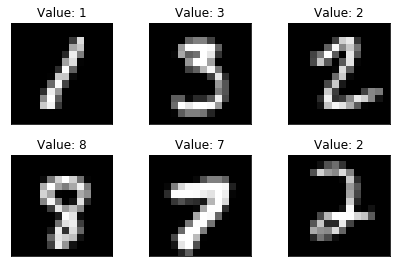

In [4]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

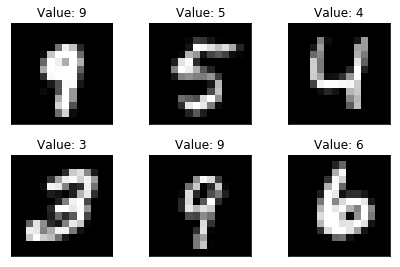

In [5]:
# displaying samples of data
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][1], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][1]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

# First neural net
Train the model on all the 2000 images in train_input

In [6]:
my_train_input1 = train_input[:,0,:]
my_train_input2 = train_input[:,1,:]
my_train_classes1 = train_classes[0:size,0]
my_train_classes2 = train_classes[0:size,1]

my_test_input1 = test_input[:,0,:]
my_test_input2 = test_input[:,1,:]
my_test_classes1 = test_classes[0:size,0]
my_test_classes2 = test_classes[0:size,1]

In [7]:
# number of epoch
num_epochs = 25
# batch size to compute mini-batch
batch_size = 2
# number of pixels in the image 
input_size = 10
# number of possible digit: 0 to 9 
num_class = 2
# small step to find a minima
learning_rate = 0.001
# hidden size
hidden_size = 50

In [8]:
def test_accuracy_based_on_imgs(model_, my_test_input1_, my_test_input2_, test_target_):
    total = my_test_input1_.size(0)
    out1, out2, result = model_(my_test_input1_, my_test_input2_, total)

    _, predictions1 = torch.max(out1.data, 1)
    _, predictions2 = torch.max(out2.data, 1)
    predictions = (predictions1 <= predictions2).long()

    well_predicted_count = (predictions == test_target_).sum().item()

    return 1 - well_predicted_count / total

In [9]:
def test_accuracy_based_on_result(model_, my_test_input1_, my_test_input2_, test_target_):
    total = my_test_input1_.size(0)
    out1, out2, result = model_(my_test_input1_, my_test_input2_, total)

    _, predictions = torch.max(result.data, 1)
    well_predicted_count = (predictions == test_target_).sum().item()
    return 1 - well_predicted_count / total

In [16]:
def train_model(model_, my_train_input1_, my_train_input2_, my_test_classes1, my_test_classes2, train_target_, criterion_, optimizer_,num_epochs_,batch_size_):

    train_error_based_on_imgs = []
    train_error_based_on_result = []
    test_error_based_on_imgs = []
    test_error_based_on_result = []
    # train function
    
    lambda_ = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_, lr_lambda=lambda_)
    
    for epoch in range(1, num_epochs_+1):
        for i in range(int(len(my_train_input1_)/batch_size_)):  
            # Move tensors to the configured device
            images1 = my_train_input1_.narrow(0,i*batch_size_,batch_size_)
            images2 = my_train_input2_.narrow(0,i*batch_size_,batch_size_)
            labels1 = my_test_classes1.narrow(0,i*batch_size_,batch_size_)
            labels2 = my_test_classes2.narrow(0,i*batch_size_,batch_size_)
            target_labels = train_target_.narrow(0,i*batch_size_,batch_size_)
            
            # Forward pass
            out1, out2, result = model_(images1, images2, batch_size_)

            loss1 = criterion_(out1, labels1)
            loss2 = criterion_(out2, labels2)
            loss3 = criterion_(result, target_labels)
            real_loss = loss3

            # Backward and optimize
            optimizer_.zero_grad()
            real_loss.backward()
            optimizer_.step()            


        scheduler.step()
    train_error_based_on_imgs.append(test_accuracy_based_on_imgs(model_, my_train_input1_, my_train_input2_, train_target))
    train_error_based_on_result.append(test_accuracy_based_on_result(model_, my_train_input1_, my_train_input2_, train_target))
    test_error_based_on_imgs.append(test_accuracy_based_on_imgs(model_, my_test_input1, my_test_input2, test_target))
    test_error_based_on_result.append(test_accuracy_based_on_result(model_, my_test_input1, my_test_input2, test_target))

    if(epoch == 25):    
        print ('Loss: {:.4f} on epoch: {}, train error based on imgs and result: {:.5f}, {:.5f}; test error: {:.5f}, {:.5f}'.format(real_loss.item(),epoch,train_error_based_on_imgs[-1],train_error_based_on_result[-1],test_error_based_on_imgs[-1],test_error_based_on_result[-1]))
    return train_error_based_on_imgs, train_error_based_on_result, test_error_based_on_imgs, test_error_based_on_result

In [17]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        #self.drop_out = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        
        
        self.layer1_ = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.layer2_ = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        #self.drop_out = nn.Dropout(0.2)
        self.fc1_ = nn.Linear(64, hidden_size)
        self.fc2_ = nn.Linear(hidden_size, 10)
        
        self.layer1_comp = nn.Linear(20, 200) 
        self.relu = nn.ReLU()
        self.layer2_comp = nn.Linear(200, 200)  
        self.layer3_comp = nn.Linear(200, 2)
    
    def forward(self, img1, img2, batch_size_images):
        img1 = img1.reshape(batch_size_images,1,14,14)
        out1 = self.layer1(img1)        
        out1 = self.layer2(out1)
        out1 = out1.reshape(out1.size(0), -1)
        #out1 = self.drop_out(out1)
        out1 = self.fc1(out1)
        out1 = self.fc2(out1)
        
        img2 = img2.reshape(batch_size_images,1,14,14)
        out2 = self.layer1_(img2)        
        out2 = self.layer2_(out2)
        out2 = out2.reshape(out2.size(0), -1)
        #out2 = self.drop_out(out2)
        out2 = self.fc1_(out2)
        out2 = self.relu(out2)
        out2 = self.fc2_(out2)

        result = torch.cat((out1,out2), dim=1, out=None)
        
        result = self.layer1_comp(result)
        result = self.relu(result)
        result = self.layer2_comp(result)
        result = self.relu(result)
        result = self.layer3_comp(result)
        
        return out1, out2, result
  
# creating neural net
model = NeuralNet(input_size, hidden_size, num_class)

# CrossEntropyLoss and optimizer which minimize loss with learning rate step
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

train_error_based_on_imgs, train_error_based_on_result, test_error_based_on_imgs, test_error_based_on_result = train_model(model, my_train_input1, my_train_input2, my_train_classes1, my_train_classes2, train_target, criterion, optimizer, num_epochs, 10)

Loss: 0.3366 on epoch: 25, train error based on imgs and result: 0.55000, 0.01200; test error: 0.54200, 0.18300


In [18]:
train_img = []
train_comp = []

test_img = []
test_comp = []

for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
    train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
    test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)

    my_train_input = train_input.reshape([2*size,196])
    my_train_classes = train_classes.reshape([2*size])

    my_train_input1 = train_input[:,0,:]
    my_train_input2 = train_input[:,1,:]
    my_train_classes1 = train_classes[0:size,0]
    my_train_classes2 = train_classes[0:size,1]

    my_test_input1 = test_input[:,0,:]
    my_test_input2 = test_input[:,1,:]
    my_test_classes1 = test_classes[0:size,0]
    my_test_classes2 = test_classes[0:size,1]
    # creating neural net
    model = NeuralNet(input_size, hidden_size, num_class)

    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

    train_error_based_on_imgs, train_error_based_on_result, test_error_based_on_imgs, test_error_based_on_result = train_model(model, my_train_input1, my_train_input2, my_train_classes1, my_train_classes2, train_target, criterion, optimizer, num_epochs, 10)
    train_img.append(train_error_based_on_imgs)
    train_comp.append(train_error_based_on_result)
    test_img.append(test_error_based_on_imgs)
    test_comp.append(test_error_based_on_result)

Loss: 0.1525 on epoch: 25, train error based on imgs and result: 0.25200, 0.04700; test error: 0.32900, 0.20700
Loss: 0.0268 on epoch: 25, train error based on imgs and result: 0.62200, 0.02100; test error: 0.60300, 0.17400
Loss: 0.0831 on epoch: 25, train error based on imgs and result: 0.44200, 0.02700; test error: 0.47300, 0.18000
Loss: 0.0107 on epoch: 25, train error based on imgs and result: 0.66000, 0.03500; test error: 0.60100, 0.19000
Loss: 0.0636 on epoch: 25, train error based on imgs and result: 0.46000, 0.04200; test error: 0.44900, 0.17900
Loss: 0.0943 on epoch: 25, train error based on imgs and result: 0.25800, 0.02900; test error: 0.35200, 0.17800
Loss: 0.0508 on epoch: 25, train error based on imgs and result: 0.56900, 0.01400; test error: 0.50000, 0.18900
Loss: 0.0646 on epoch: 25, train error based on imgs and result: 0.50600, 0.03900; test error: 0.51800, 0.17300
Loss: 0.0831 on epoch: 25, train error based on imgs and result: 0.39900, 0.02600; test error: 0.39800, 

In [19]:
import numpy as np
print(np.std(test_img))
print(np.std(test_comp))

0.08809137301688515
0.009749358953285046


In [20]:
print(np.mean(test_img))
print(np.mean(test_comp))

0.4681
0.18250000000000002


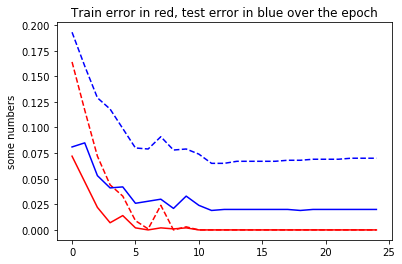

In [49]:
plt.plot(train_error_based_on_imgs, 'r', train_error_based_on_result, 'r--', test_error_based_on_imgs, 'b', test_error_based_on_result, 'b--')
plt.ylabel('some numbers')
plt.title("Train error in red, test error in blue over the epoch")
plt.show()

In [50]:
print("Accuracy: {}".format(1-min(test_error_based_on_imgs)))

Accuracy: 0.981
